In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import mne
import yasa
import time

In [110]:
def benchmark(label_data, pred_data):
# OFffline BenchMark
    result_matrix = np.zeros([4, 8])
    if max(label_data) == 3:
        remap1 = [0, 1, 2, 3]
    else:
        remap1 = [0, 0, 1, 2, 3]
    
    if max(pred_data) == 3:
        remap2 = [0, 1, 2, 3]
    else:
        remap2 = [0, 0, 1, 2, 3]
    
    count = 0

    for i in range(len(label_data)):
        y = remap1[label_data[i]]
        pred = remap2[pred_data[i]]
        result_matrix[y][pred] += 1
        if y == pred:
            count += 1
    ACC = count / len(label_data)
    ACC = round(ACC * 100, 3)

    for target in range(4):
        # Offline BenchMark
        TP = 0
        FP = 0
        TN = 0
        FN = 0

        for i in range(len(label_data)):
            y = remap1[label_data[i]]
            pred = remap2[pred_data[i]]
            if y == target and pred == target:
                TP += 1
            elif y != target and pred != target and y == pred:
                TN += 1
            elif y == target and pred != target:
                FN += 1
            elif y != target and pred == target:
                FP += 1

        try:
            TPR = TP / (TP + FP)
        except ZeroDivisionError:
            TPR = 0
        finally:
            result_matrix[target][4] = round(TPR * 100, 3)

        try:
            FPR = FP / (FP + TN)
        except ZeroDivisionError:
            FPR = 0
        finally:
            result_matrix[target][5] = round(FPR * 100, 3)

        try:
            RC = TP / (TP + FN)
        except ZeroDivisionError:
            RC = 0
        finally:
            result_matrix[target][6] = round(RC * 100, 3)

        try:
            F = (TPR * RC * 2) / (TPR + RC)
        except ZeroDivisionError:
            F = 0
        finally:
            result_matrix[target][7] = round(F * 100, 3)
    print("Total Accuracy:", ACC)
    r = result_matrix.T
    row_name = ["W/N1", "N2", "N3", "REM"]
    dataFrame = {"GT": row_name, "W/N1": r[0], "N2": r[1], "N3": r[2], "REM": r[3], "TPR": r[4], "FPR": r[5], "RC": r[6], "F": r[7]}
    dataFrame = pd.DataFrame(dataFrame)
    return result_matrix, dataFrame, ACC

In [1]:
def my_plot_hypnogram(hypno, sf_hypno=1 / 30, lw=1.5, fill_color=None, ax=None):
    """
    Plot a hypnogram.
    
    Parameters
    ----------
    hypno : array_like
        Sleep stage (hypnogram).

        .. note::
            The default hypnogram format in YASA is a 1D integer vector where:

            * 0 = Wake / N1 sleep
            * 2 = N2 sleep
            * 3 = N3 sleep
            * 4 = REM sleep
            
            Combine N2 and N3 together, use remapping:
            * 0 = Wake / N1 sleep
            * 1 = N2 sleep / N3 sleep
            * 2 = REM sleep
            
    sf_hypno : float
        The current sampling frequency of the hypnogram, in Hz, e.g.

        * 1/30 = 1 value per each 30 seconds of EEG data,
        * 1 = 1 value per second of EEG data
    lw : float
        Linewidth.
    fill_color : str
        Color to fill space above hypnogram line, optional.
    ax : :py:class:`matplotlib.axes.Axes`
        Axis on which to draw the plot, optional.

    Returns
    -------
    ax : :py:class:`matplotlib.axes.Axes`
        Matplotlib Axes
    """
    # Increase font size while preserving original
    old_fontsize = plt.rcParams["font.size"]
    plt.rcParams.update({"font.size": 18})

    # Safety checks
    assert isinstance(hypno, (np.ndarray, pd.Series, list)), "hypno must be an array."
    hypno = np.asarray(hypno).astype(int)
    assert hypno.ndim == 1, "hypno must be a 1D array."
    assert isinstance(sf_hypno, (int, float)), "sf must be int or float."

    bins = np.arange(hypno.size + 1) / (sf_hypno * 3600)
    # Make sure that REM is displayed after Wake
    hypno = pd.Series(hypno).map({0: 0, 1: 0, 2: 2, 3: 3, 4: 1}).values

    # Reduce data and bin edges to only moments of change in the hypnogram
    # (to avoid drawing thousands of tiny individual lines when sf is high)
    change_points = np.nonzero(np.ediff1d(hypno, to_end=1))
    hypno = hypno[change_points]
    bins = np.append(0, bins[change_points])

    # Make masks for REM and Artefact/Unscored
    hypno_rem = np.ma.masked_not_equal(hypno, 1)
    hypno_sleep = np.ma.masked_less(hypno, 0)

    # Start the plot
    if ax is None:
        ax = plt.gca()

    # Draw background filling
    if fill_color is not None:
        ax.stairs(-1 * hypno.clip(0), bins, fill=True, color=fill_color, lw=0)
    # Draw main hypnogram line
    ax.stairs(-1 * hypno, bins, baseline=None, color="k", lw=lw)
    # Draw REM and Artefact/Unscored highlighting
    if 1 in hypno:
        ax.hlines(-1 * hypno_rem, xmin=bins[:-1], xmax=bins[1:], color="red", lw=lw)
    # Determine y-axis labels and limits
    # No artefacts or Unscored
    ax.set_yticks([0, -1, -2, -3])
    ax.set_yticklabels(["W/N1", "R", "N2", "N3"])
    ax.set_ylim(-3.5, 0.5)
    
    ax.set_xlim(0, bins.max())
    ax.set_ylabel("Stage")
    ax.set_xlabel("Time [hrs]")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # Revert font-size
    plt.rcParams.update({"font.size": old_fontsize})
    return ax

SyntaxError: EOF while scanning triple-quoted string literal (265300692.py, line 88)

In [106]:
def confusionPlot(confusion_matrix, ax=None):
    num_classes = 4
    class_names = ["W/N1", "N2", "N3", "REM"]                

#     plt.figure()
#     fig, ax = plt.subplots()
    if ax is None:
        ax = plt.gca()
    confusion_matrix = confusion_matrix[:, :4]
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)

    tick_marks = np.arange(num_classes)
    classNames = class_names

    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j]), fontsize=20,
                    ha="center", va="center",
                    color="white" if  confusion_matrix[i, j] == 0 or confusion_matrix[i, j] > thresh else "black") 
    plt.xticks([0, 1, 2, 3])
    ax.set_xticklabels(class_names, fontsize=20)
    ax.xaxis.tick_top()
    
    plt.yticks([0, 1, 2, 3])
    ax.set_yticklabels(class_names, fontsize=20)
    
#     plt.tight_layout()
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=16)
#     plt.show()
    return ax

In [107]:
def ROC(confusion_matrix, ax=None):
    num_classes = 4
    class_names = ["W/N1", "N2", "N3", "REM"]

#     plt.figure()
#     fig, ax = plt.subplots()
    if ax is None:
        ax = plt.gca()
    confusion_matrix = confusion_matrix[:, 4:]
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)

    tick_marks = np.arange(num_classes)
    classNames = class_names

    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j]), fontsize=20,
                    ha="center", va="center",
                    color="white" if  confusion_matrix[i, j] == 0 or confusion_matrix[i, j] > thresh else "black") 
    plt.xticks([0, 1, 2, 3])
    ax.set_xticklabels(["TPR", "FPR", "RC", "F1"], fontsize=20)
    ax.xaxis.tick_top()
    
    plt.yticks([0, 1, 2, 3])
    ax.set_yticklabels(["W/N1", "N2", "N3", "REM"], fontsize=20)
    
#     plt.tight_layout()
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=16)
#     plt.show()
    return ax

In [127]:
def GeneralPlot(HYP1, HYP2, confusionMatrix, ACC, HYP1_Label="Yasa-OL", HYP2_Label="Model-OL", mode=0, showpic=True):
    fig = plt.figure(figsize=(25,15))
    
    ax1 = plt.subplot(5, 1, 1)
    ax1 = my_plot_hypnogram(HYP1, sf_hypno=1, ax=ax1)
    ax1.set_xlabel('Time[hrs]', fontsize=18)
    ax1.set_ylabel('Stage', fontsize=20)
    ax1.tick_params(axis='x', labelsize=18)
    ax1.tick_params(axis='y', labelsize=16)
    ax1.set_title(HYP1_Label, fontsize=26, loc="left")
    
    ax2 = plt.subplot(5, 1, 2)
    ax2 = my_plot_hypnogram(HYP2, sf_hypno=1, ax=ax2)
    ax2.set_xlabel('Time[hrs]', fontsize=18)
    ax2.set_ylabel('Stage', fontsize=20)
    ax2.tick_params(axis='x', labelsize=18)
    ax2.tick_params(axis='y', labelsize=16)
    ax2.set_title(HYP2_Label, fontsize=26, loc="left")
    
    ax3 = plt.subplot(5, 2, (5, 9))
    ax3 = confusionPlot(confusionMatrix)
    
    
    ax4 = plt.subplot(5, 2, (6, 10))
    ax4 = ROC(confusionMatrix)
    
    fig.tight_layout()
    savename = ["GT_OL VS Model_OL", "GT_OL VS Yasa_OL", "Yasa_OL VS Model_OL"]
    plt.suptitle('%s: %.2f%%' % (savename[mode], ACC),fontsize=28)
    plt.savefig(path + "/saveImg/%s.png" % savename[mode])
    if showpic:
        plt.show()
    else:
        plt.close()

In [128]:
# DataIndx
# This is the only parameters you can change in this program!

indx = 3
dataBase = "FL"
path = "Result/%s/%s_%03d" % (dataBase, dataBase, indx)
if not os.path.exists(path+"/saveImg"):
    os.mkdir(path+"/saveImg")
print("Use Data From %s data %03d" % (dataBase, indx))
print("Search path:", path)
# Data Loader
GroundTruth = np.load(path + "/GroundTruth.npy")
Offline_yasa = np.load(path + "/Offline_yasa.npy")
Offline_model = np.load(path + "/Offline_model.npy")

Use Data From FL data 003
Search path: Result/FL/FL_003


In [130]:
dataBase = "Fl"
paths = glob.glob("Result/%s/*" % dataBase)
for path in paths:
    now = time.time()
    indx = int(path[-3:])
    if not os.path.exists(path+"/saveImg"):
        os.mkdir(path+"/saveImg")
    print("Use Data From %s data %03d" % (dataBase, indx))
    print("Search path:", path)
    # Data Loader
    GroundTruth = np.load(path + "/GroundTruth.npy")
    Offline_yasa = np.load(path + "/Offline_yasa.npy")
    Offline_model = np.load(path + "/Offline_model.npy")
    
    result_matrix_1, dataFrame_1, ACC_1 = benchmark(GroundTruth, Offline_model)
    GeneralPlot(GroundTruth, Offline_model, result_matrix_1, ACC_1, HYP1_Label="GT-OL", HYP2_Label="Model-OL", mode=0, showpic=False)
    
    result_matrix_2, dataFrame_2, ACC_2 = benchmark(GroundTruth, Offline_yasa)
    GeneralPlot(GroundTruth, Offline_yasa, result_matrix_2, ACC_2, HYP1_Label="GT-OL", HYP2_Label="Yasa-OL", mode=1, showpic=False)
    
    result_matrix_3, dataFrame_3, ACC_3 = benchmark(Offline_yasa, Offline_model)
    GeneralPlot(Offline_yasa, Offline_model, result_matrix_3, ACC_3, HYP1_Label="Yasa-OL", HYP2_Label="Model-OL", mode=2, showpic=False)
    print("Done! Use time: %.3fs\n" % (time.time() - now))
    # break

Use Data From Fl data 003
Search path: Result/Fl\FL_003
Total Accuracy: 88.257
Total Accuracy: 95.056
Total Accuracy: 87.021
Done! Use time: 1.207s

Use Data From Fl data 006
Search path: Result/Fl\FL_006
Total Accuracy: 88.889
Total Accuracy: 95.181
Total Accuracy: 87.818
Done! Use time: 1.352s

Use Data From Fl data 007
Search path: Result/Fl\FL_007
Total Accuracy: 68.98
Total Accuracy: 92.245
Total Accuracy: 70.884
Done! Use time: 1.205s

Use Data From Fl data 009
Search path: Result/Fl\FL_009
Total Accuracy: 83.139
Total Accuracy: 96.239
Total Accuracy: 82.361
Done! Use time: 1.967s

Use Data From Fl data 012
Search path: Result/Fl\FL_012
Total Accuracy: 85.072
Total Accuracy: 91.332
Total Accuracy: 83.467
Done! Use time: 1.092s

Use Data From Fl data 013
Search path: Result/Fl\FL_013
Total Accuracy: 73.314
Total Accuracy: 86.801
Total Accuracy: 75.179
Done! Use time: 1.097s

Use Data From Fl data 014
Search path: Result/Fl\FL_014
Total Accuracy: 81.005
Total Accuracy: 93.25
Total 

mode 0: GT_OL VS Model_OL
mode 1: GT_OL VS Yasa_OL
mode 2: Yasa_OL VS Model_OL

Total Accuracy: 41.286


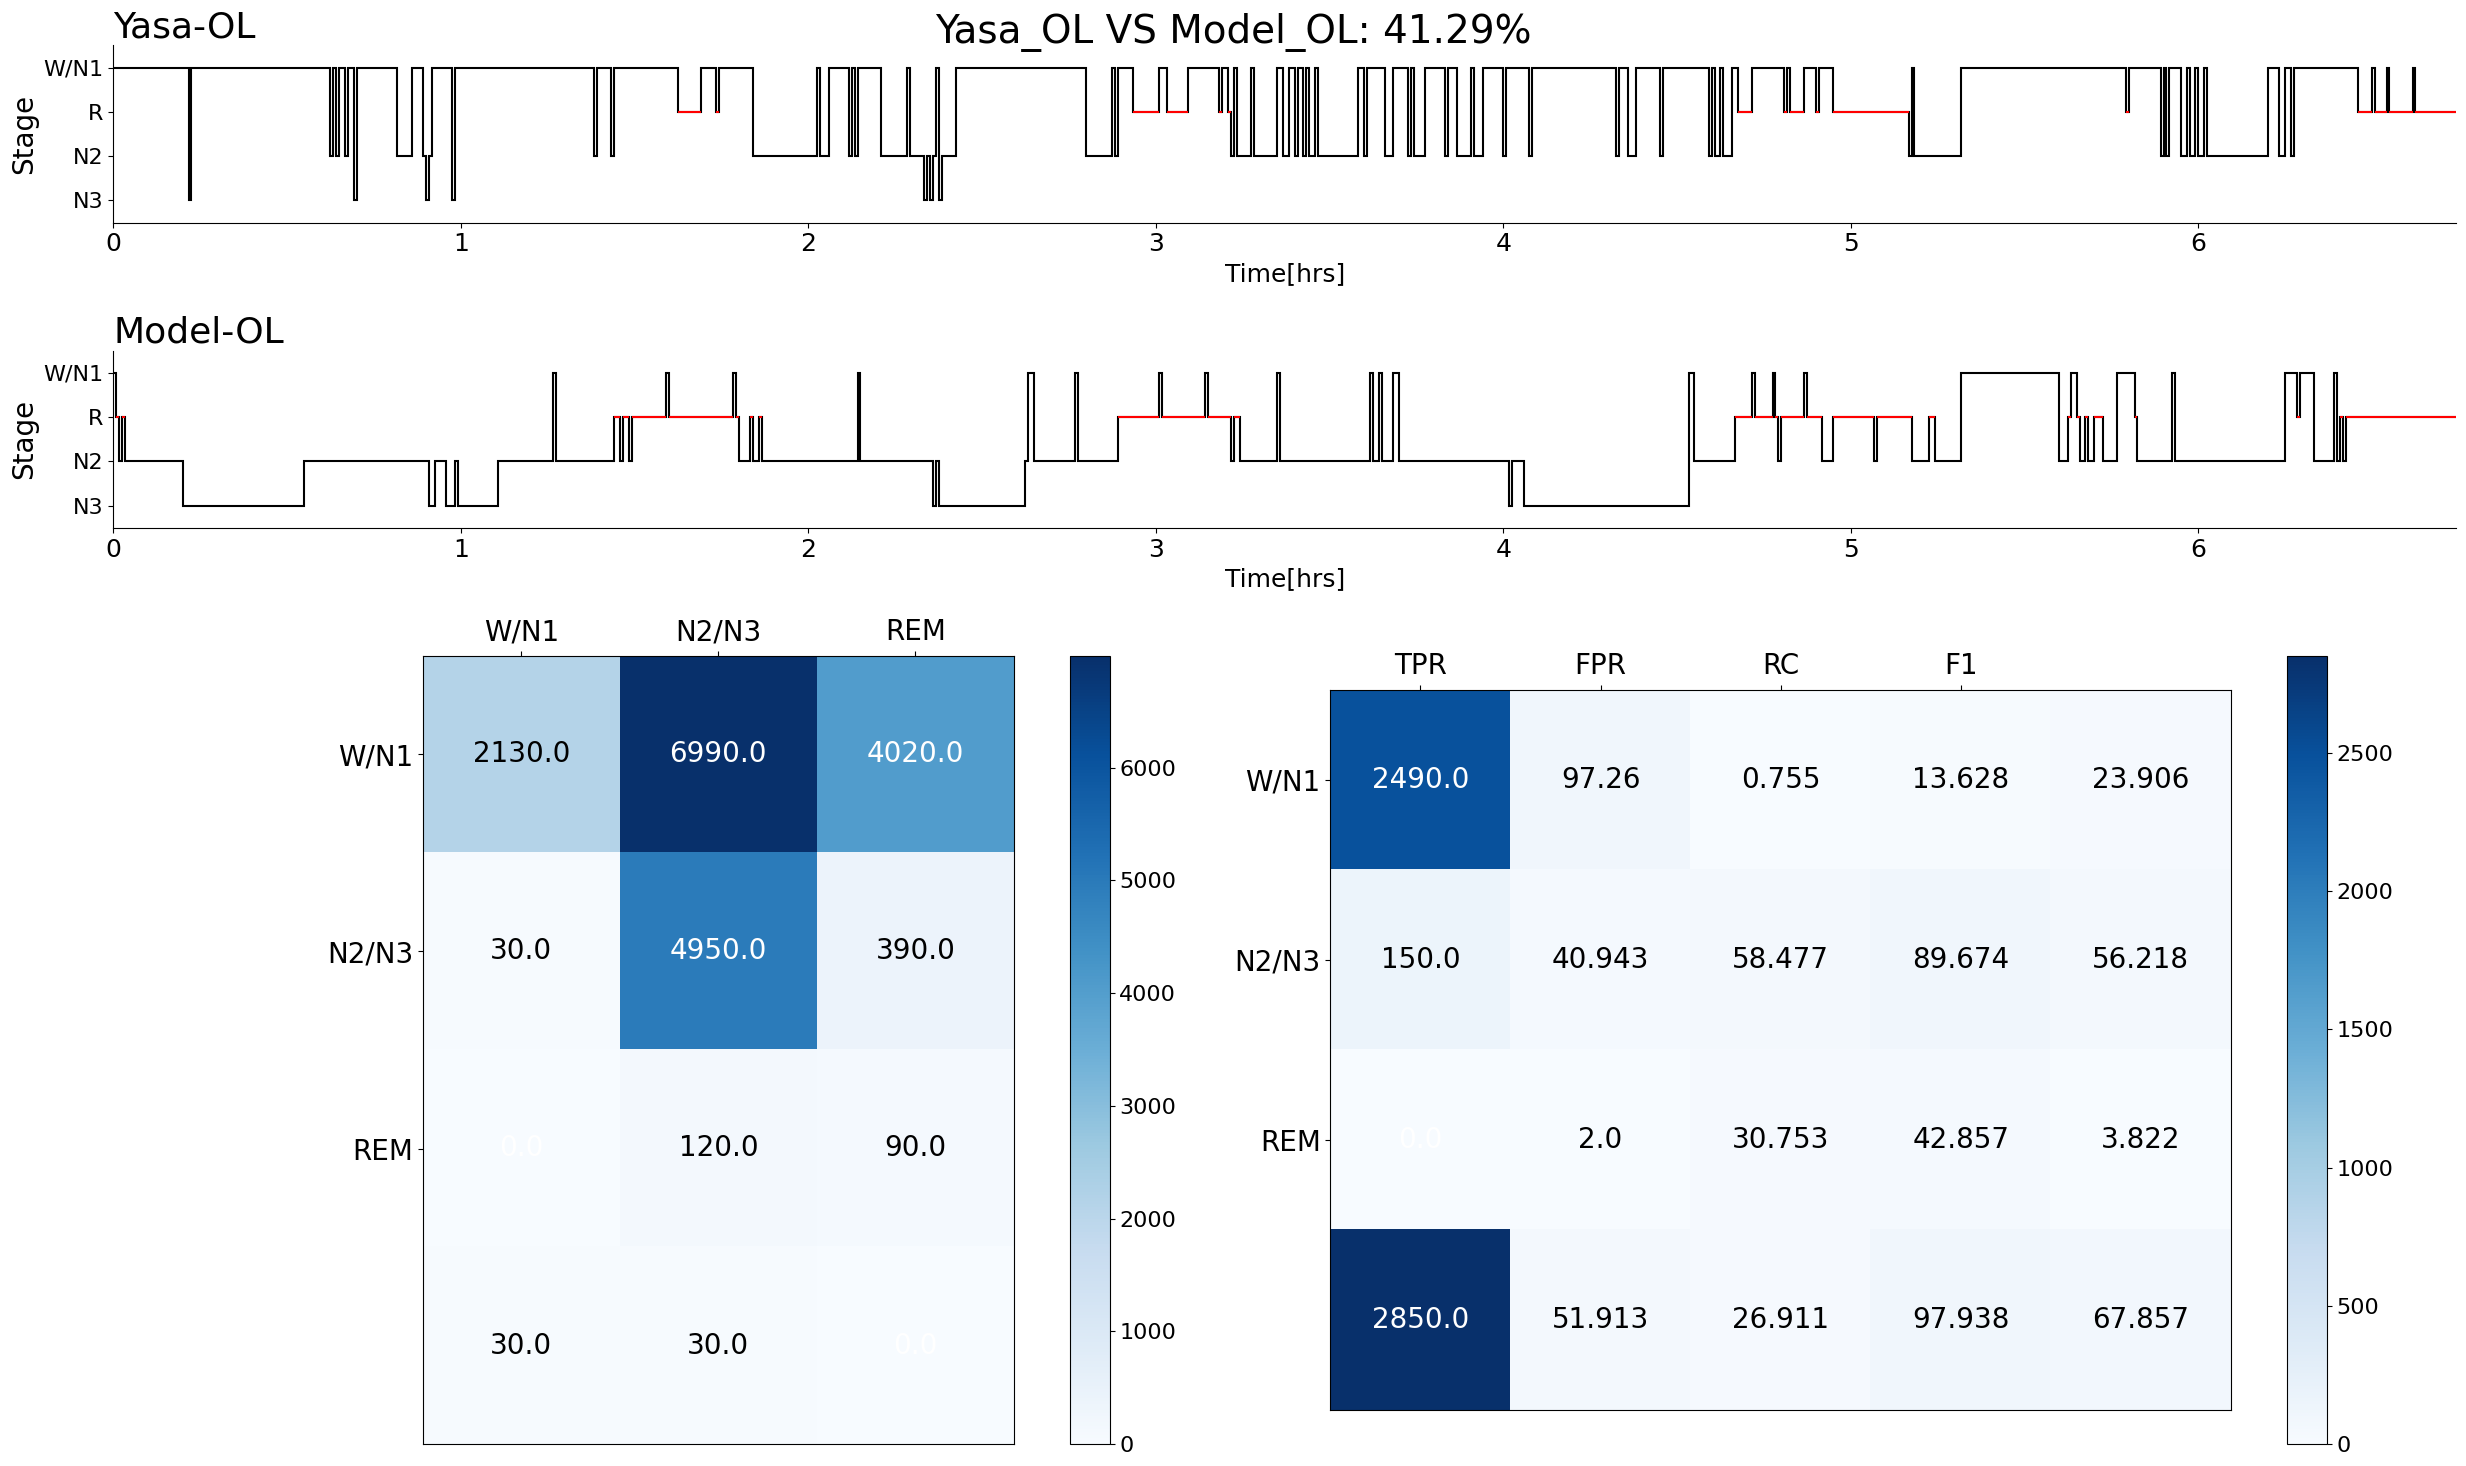

FileNotFoundError: [Errno 2] No such file or directory: 'Result/FL/FL_003/Realtime_yasa.npy'

In [67]:
result_matrix_OL, dataFrame_OL, ACC_OL = benchmark(Offline_yasa, Offline_model)
GeneralPlot(Offline_yasa, Offline_model, result_matrix_OL, ACC_OL, HYP1_Label="Yasa-OL", HYP2_Label="Model-OL", mode=0)
Realtime_yasa = np.load(path + "/Realtime_yasa.npy")
Realtime_model = np.load(path + "/Realtime_model.npy")
Time_yasa = np.load(path + "/Realtime_yasa_time.npy")
Time_model = np.load(path + "/Realtime_model_time.npy")
result_matrix_RT, dataFrame_RT, ACC_RT = benchmark(Realtime_yasa, Realtime_model)
GeneralPlot(Realtime_yasa, Realtime_model, result_matrix_RT, ACC_RT, HYP1_Label="Yasa-RT", HYP2_Label="Model-RT", mode=1)
result_matrix_OL_RT, dataFrame_OL_RT, ACC_OL_RT = benchmark(Offline_yasa, Realtime_model)
GeneralPlot(Offline_yasa, Realtime_model, result_matrix_OL_RT, ACC_OL_RT, HYP1_Label="Yasa-OL", HYP2_Label="Model-RT", mode=2)
result_matrix_Yasa, dataFrame_Yasa, ACC_Yasa = benchmark(Offline_yasa, Realtime_yasa)
GeneralPlot(Offline_yasa, Realtime_yasa, result_matrix_Yasa, ACC_Yasa, HYP1_Label="Yasa-OL", HYP2_Label="Yasa-RT", mode=3)
result_matrix_Model, dataFrame_Model, ACC_Model = benchmark(Offline_model, Realtime_model)
GeneralPlot(Offline_model, Realtime_model, result_matrix_Model, ACC_Model, HYP1_Label="Model-OL", HYP2_Label="Model-RT", mode=4)

time_go = np.array(range(len(Time_model))) * 3
fig = plt.figure(figsize=(22,9))
# plt.title("Time Consume", fontsize=26)

plt.plot(time_go, Time_yasa * 1000, "k", lw=0.7, label="yasa")
plt.plot(time_go, Time_model * 1000, lw=0.7, label="my_model")

plt.ylabel('Time Consume (msec)', fontsize=16)
plt.xlabel('Time (sec)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc=1, fontsize=20)
plt.savefig(path + "/saveImg/TimeConsume.png")
plt.show()

Total Accuracy: 40.94


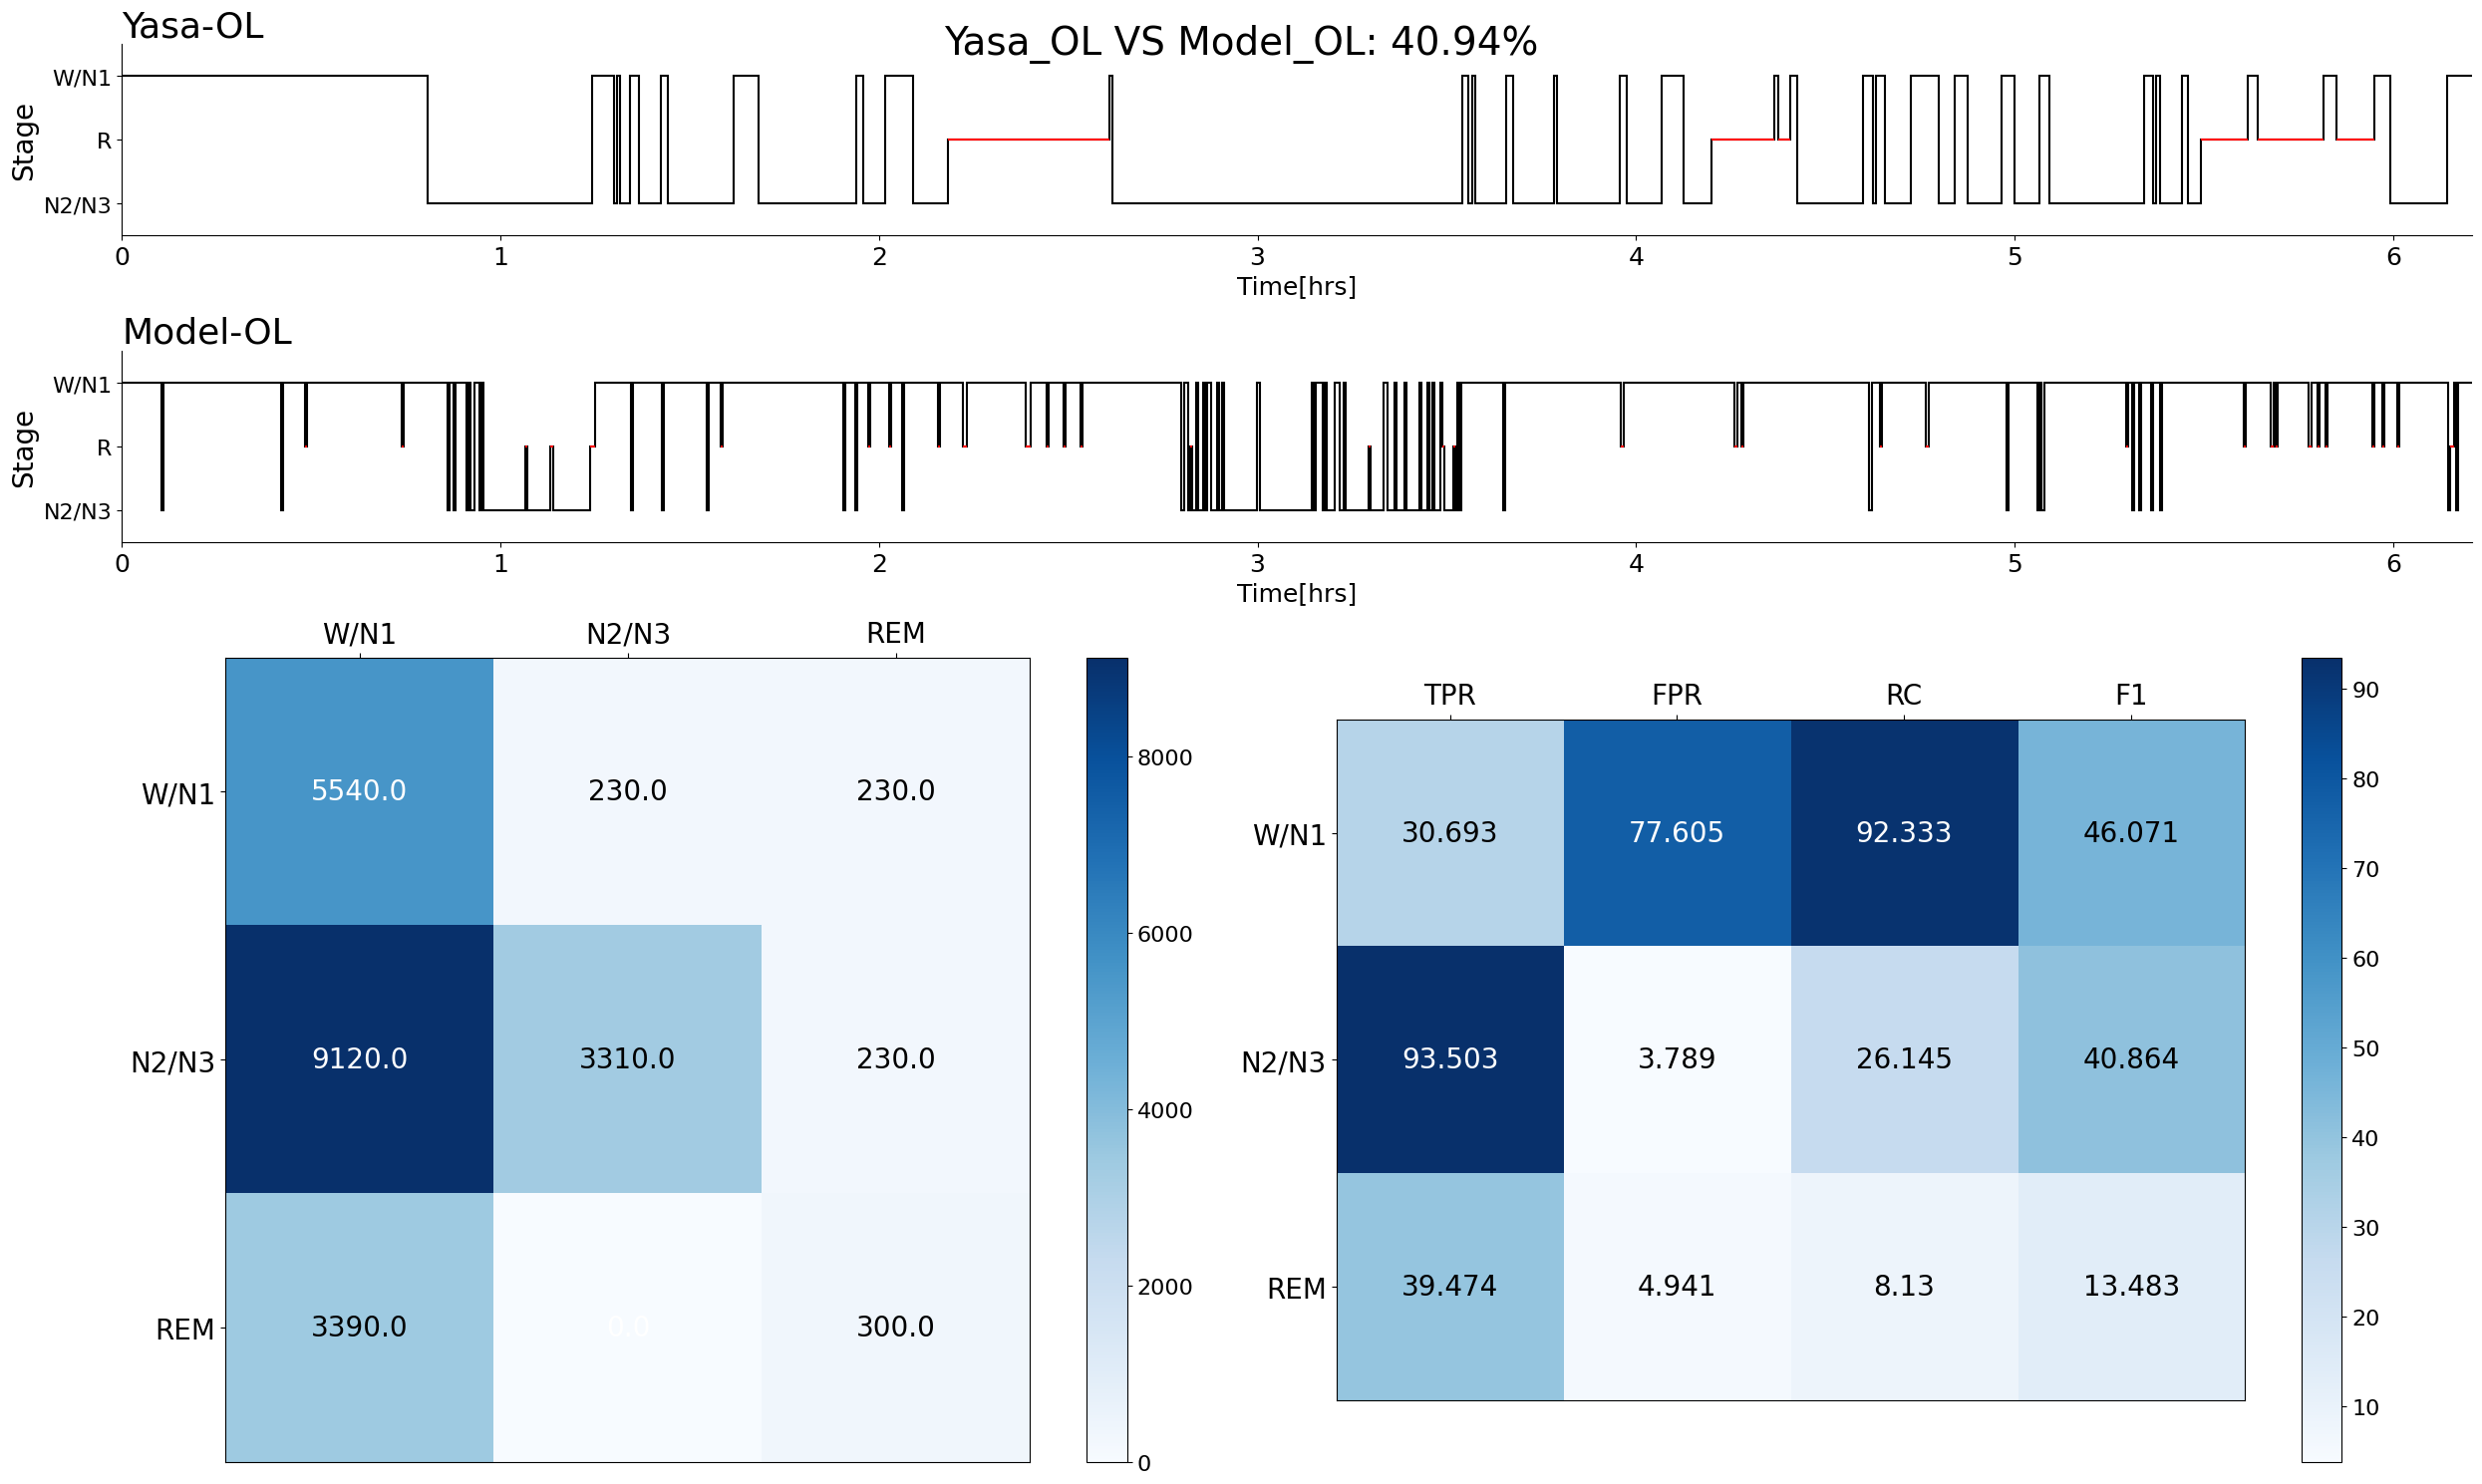

In [153]:
result_matrix_OL, dataFrame_OL, ACC_OL = benchmark(Offline_yasa, Offline_model)
GeneralPlot(Offline_yasa, Offline_model, result_matrix_OL, ACC_OL, HYP1_Label="Yasa-OL", HYP2_Label="Model-OL", mode=0)

In [138]:
Realtime_yasa = np.load(path + "/Realtime_yasa.npy")
Realtime_model = np.load(path + "/Realtime_model.npy")
Time_yasa = np.load(path + "/Realtime_yasa_time.npy")
Time_model = np.load(path + "/Realtime_model_time.npy")

Total Accuracy: 32.726


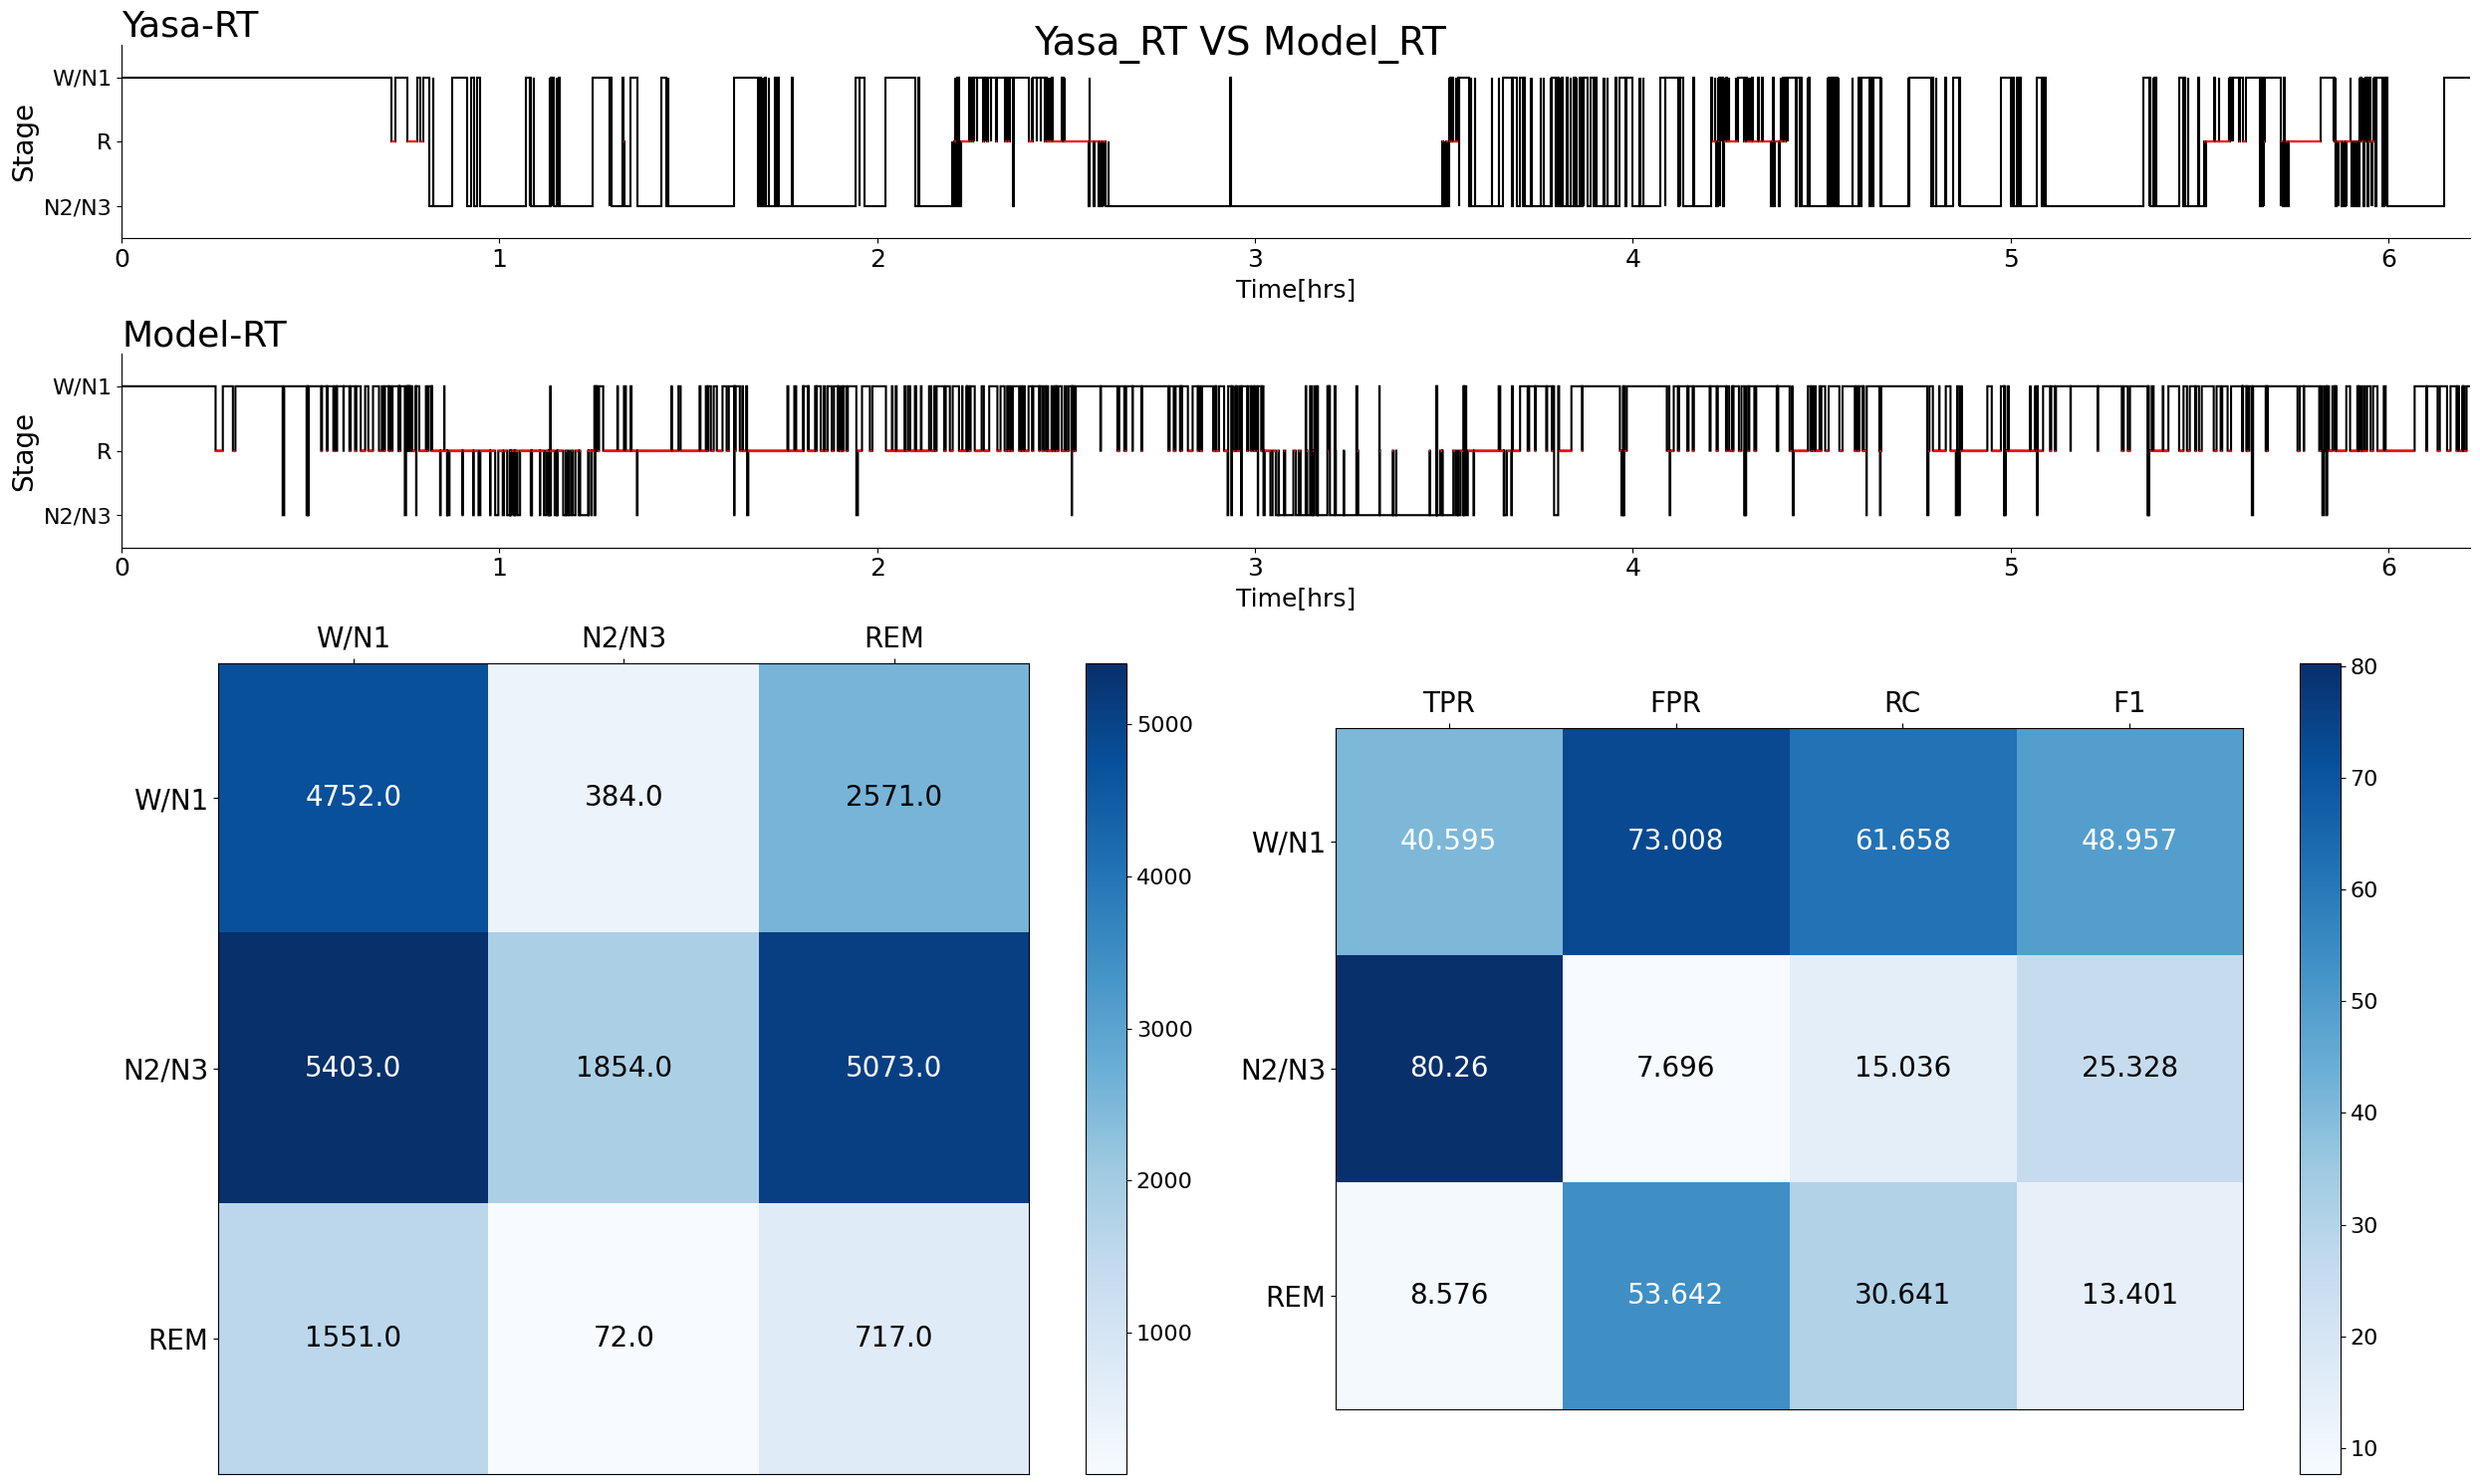

In [139]:
result_matrix_RT, dataFrame_RT, ACC_RT = benchmark(Realtime_yasa, Realtime_model)
GeneralPlot(Realtime_yasa, Realtime_model, result_matrix_RT, ACC_RT, HYP1_Label="Yasa-RT", HYP2_Label="Model-RT", mode=1)

Total Accuracy: 31.221


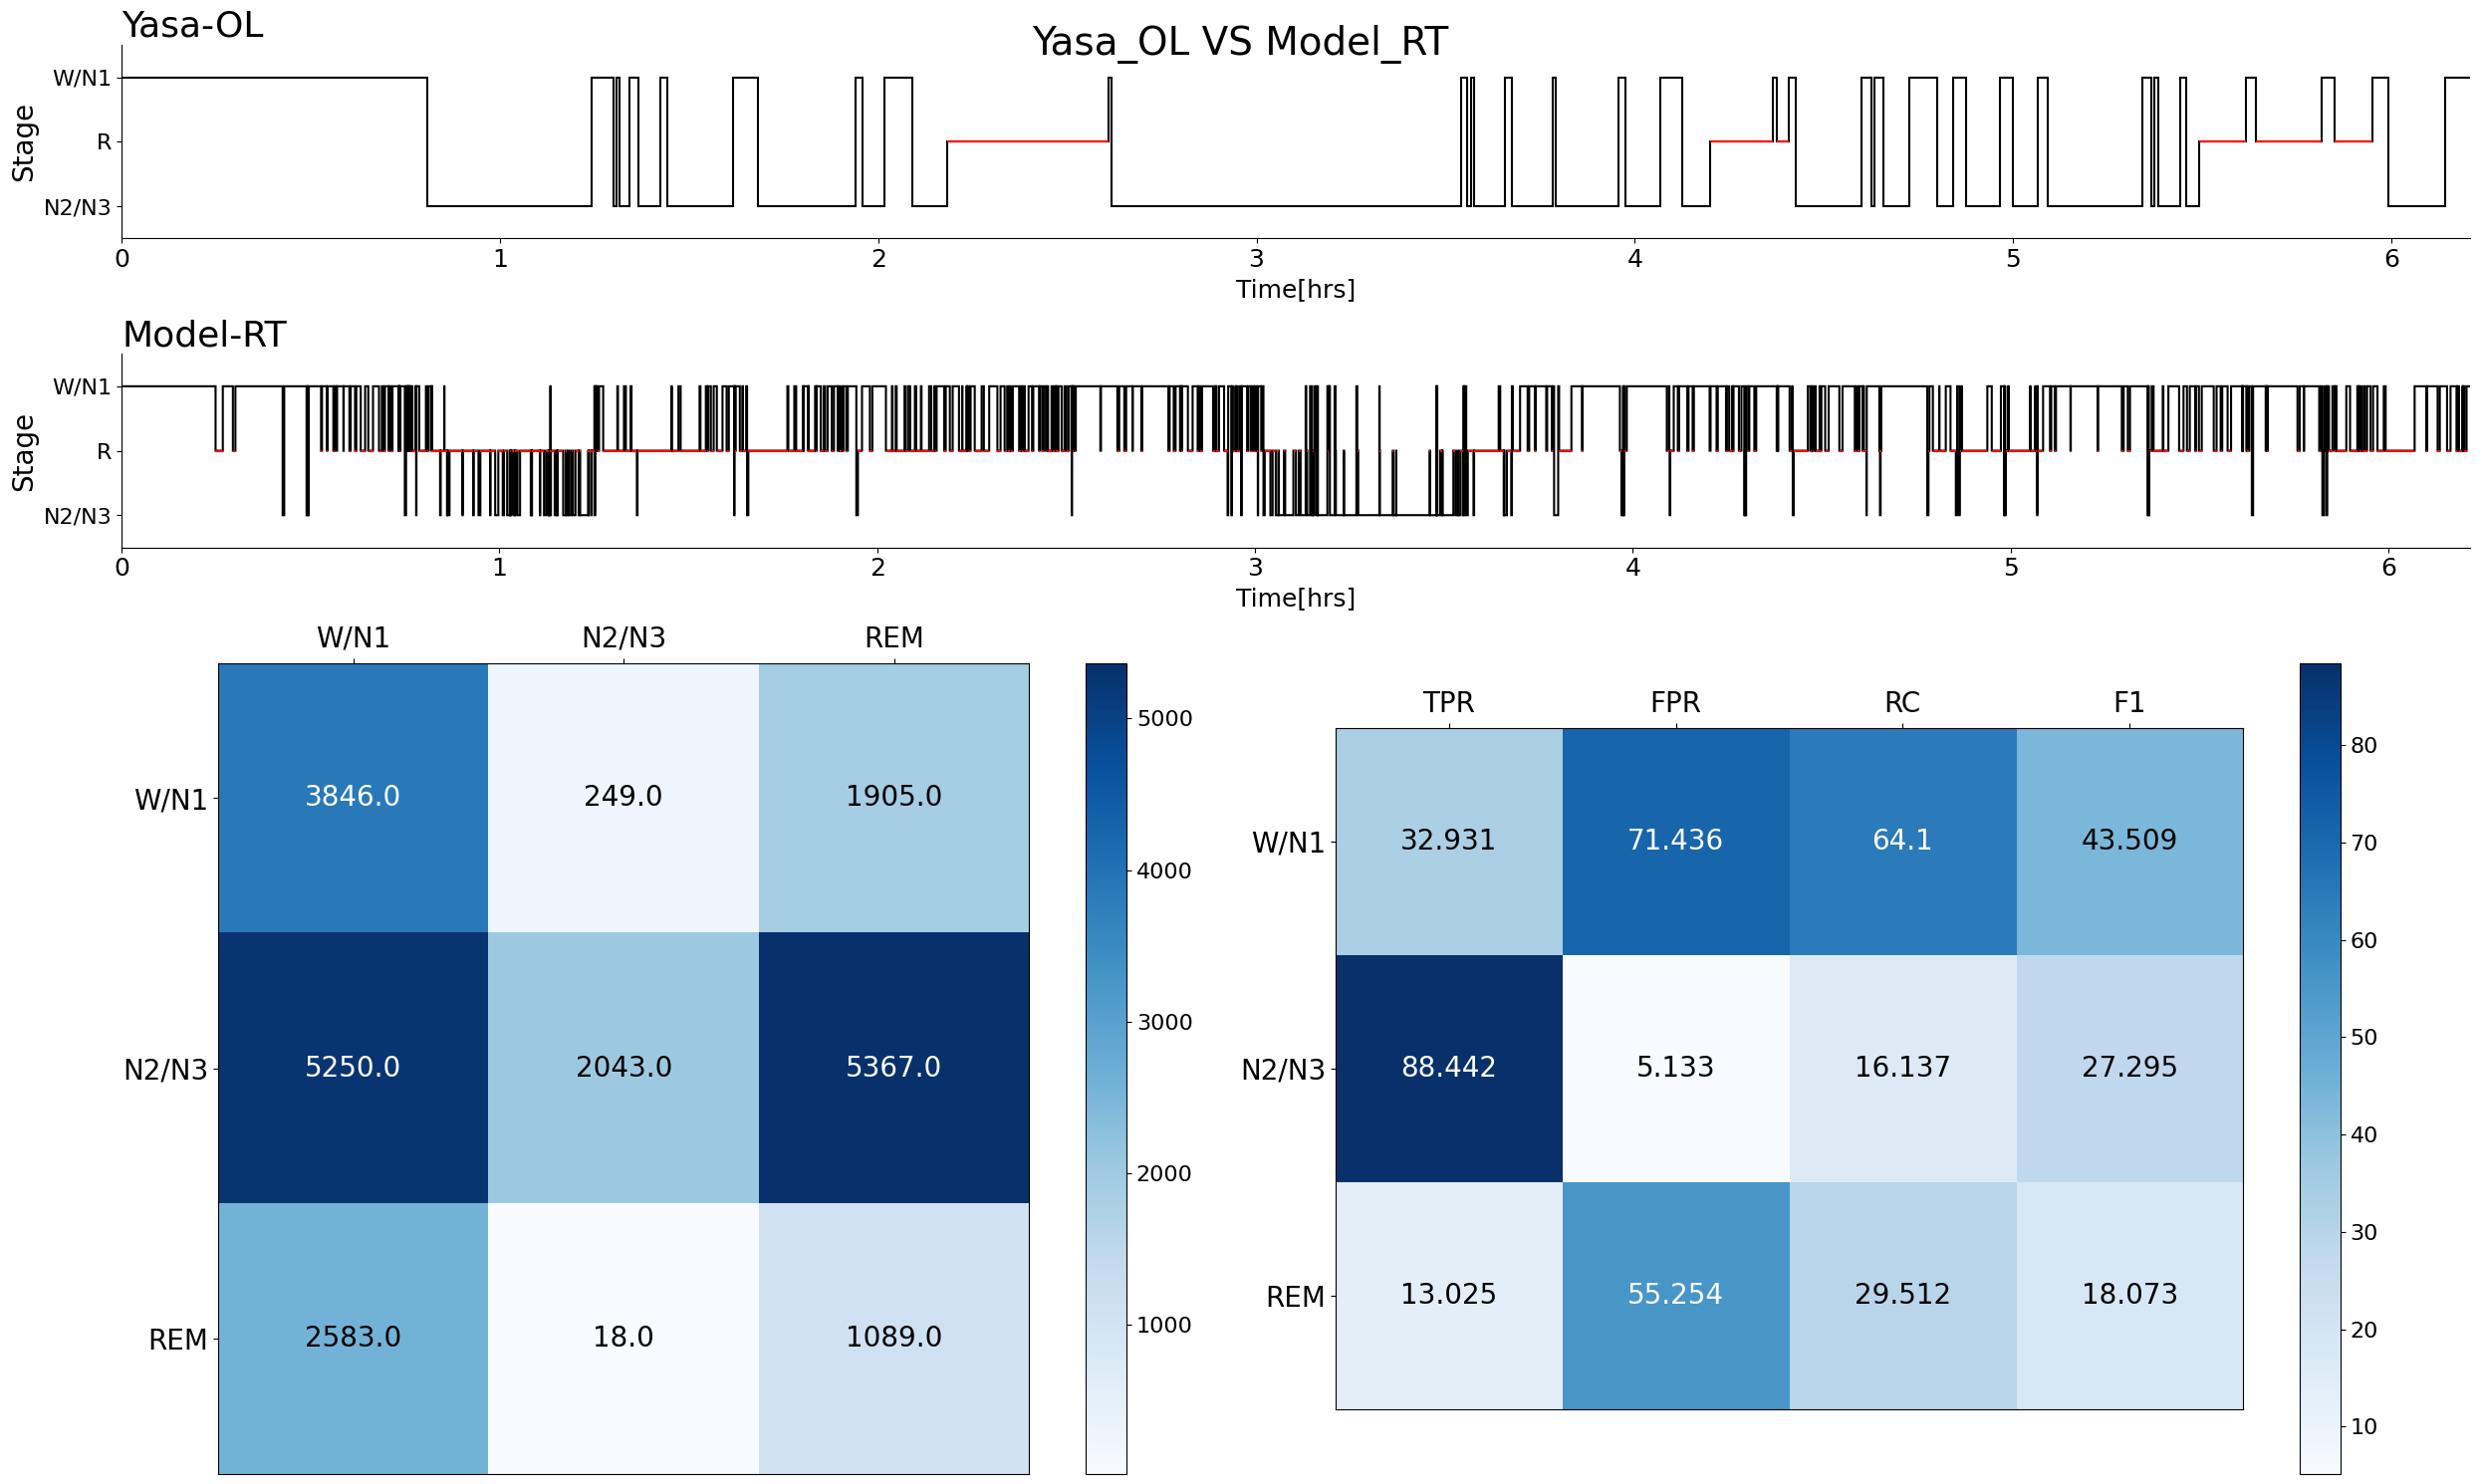

In [140]:
result_matrix_OL_RT, dataFrame_OL_RT, ACC_OL_RT = benchmark(Offline_yasa, Realtime_model)
GeneralPlot(Offline_yasa, Realtime_model, result_matrix_OL_RT, ACC_OL_RT, HYP1_Label="Yasa-OL", HYP2_Label="Model-RT", mode=2)

Total Accuracy: 82.993


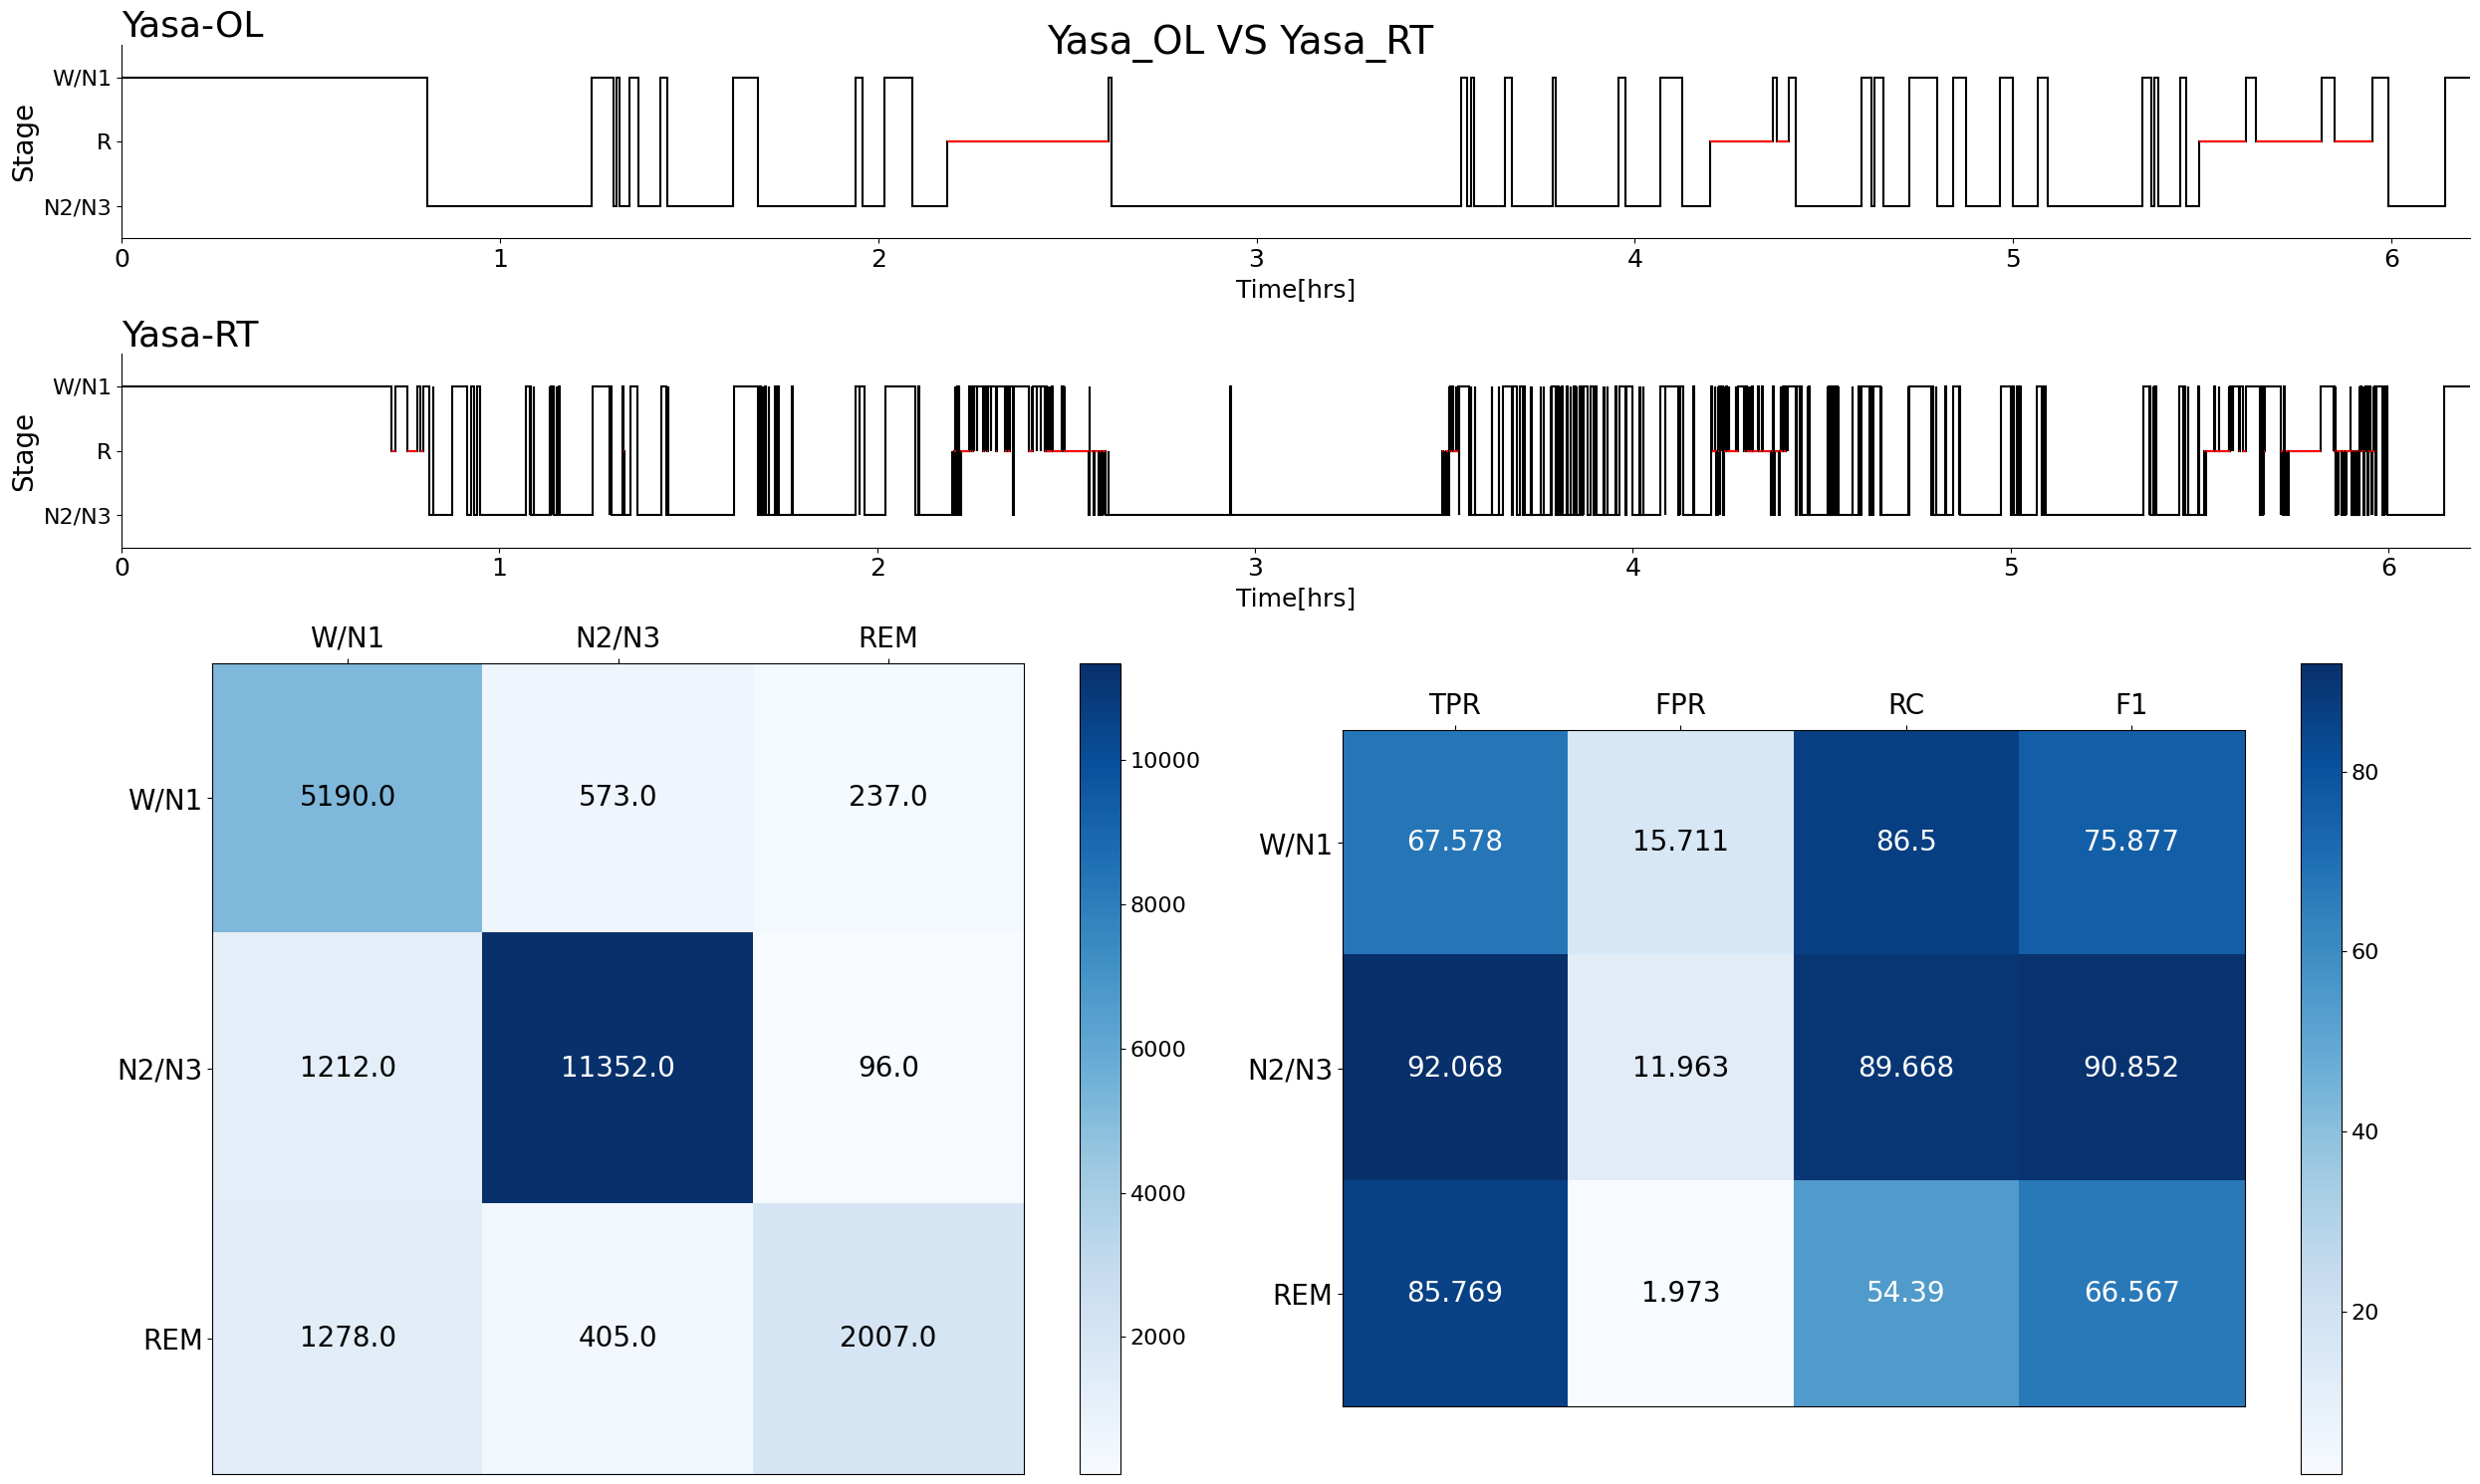

In [141]:
result_matrix_Yasa, dataFrame_Yasa, ACC_Yasa = benchmark(Offline_yasa, Realtime_yasa)
GeneralPlot(Offline_yasa, Realtime_yasa, result_matrix_Yasa, ACC_Yasa, HYP1_Label="Yasa-OL", HYP2_Label="Yasa-RT", mode=3)

Total Accuracy: 57.06


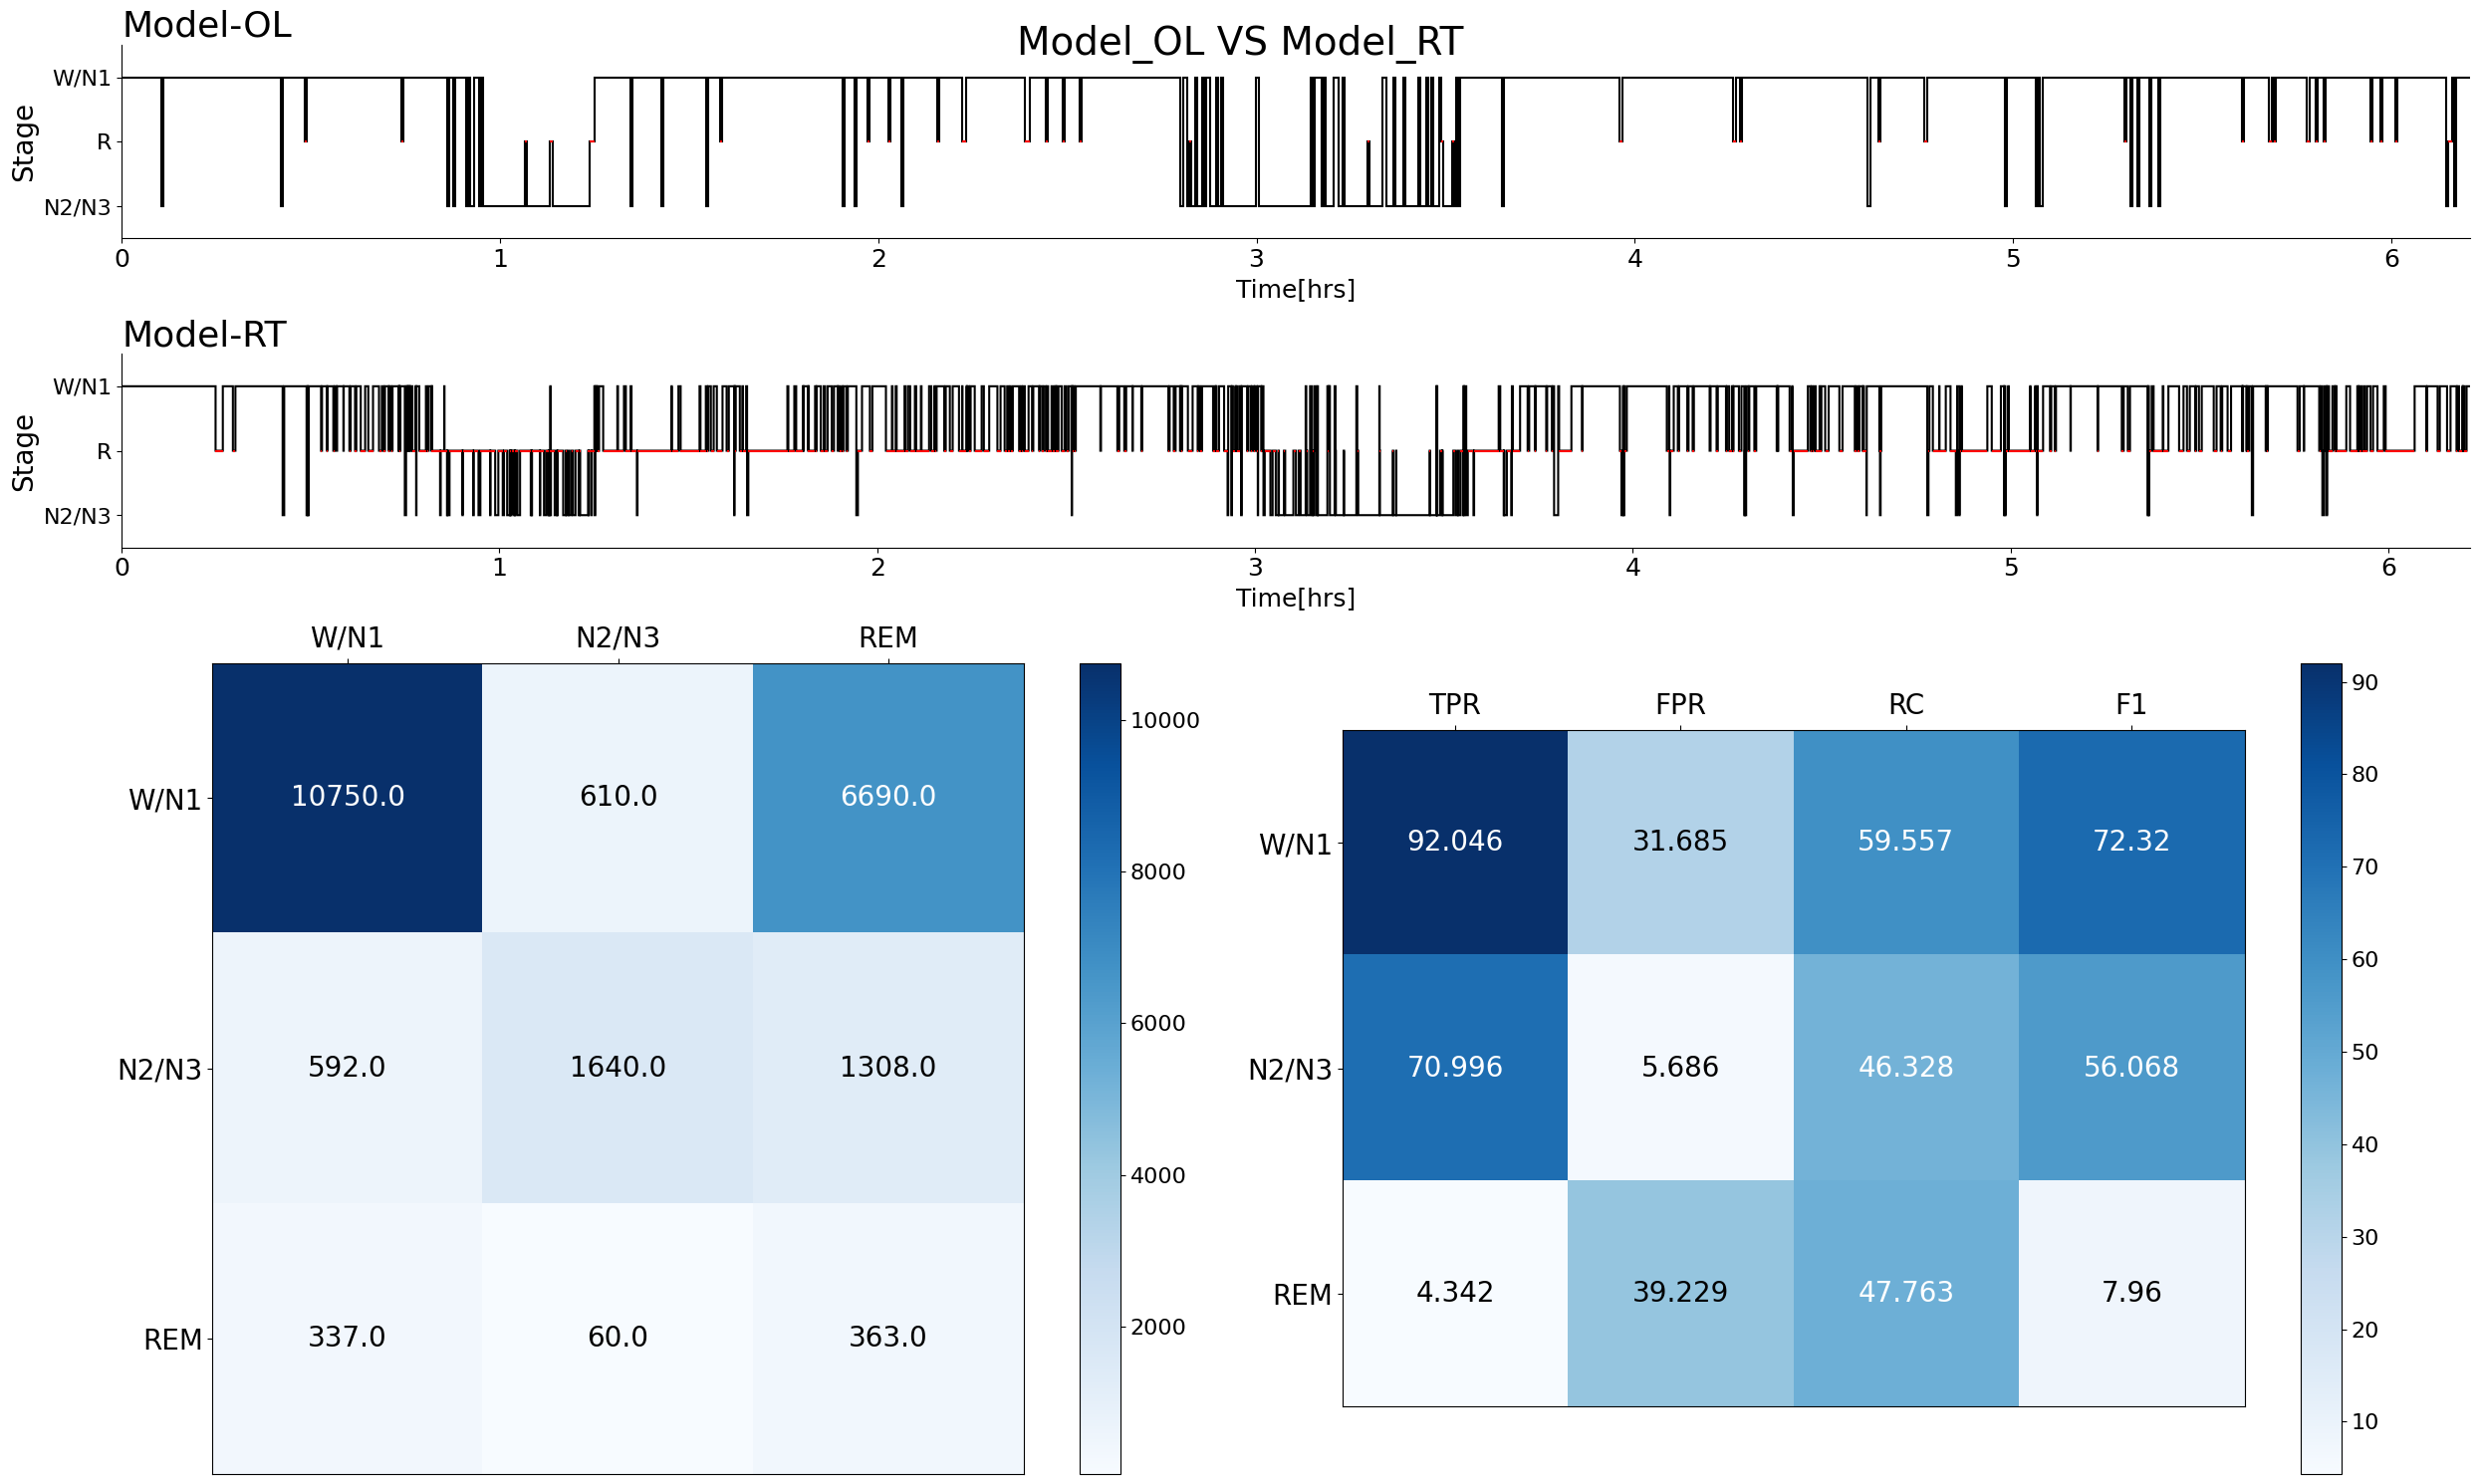

In [142]:
result_matrix_Model, dataFrame_Model, ACC_Model = benchmark(Offline_model, Realtime_model)
GeneralPlot(Offline_model, Realtime_model, result_matrix_Model， ACC_Model, HYP1_Label="Model-OL", HYP2_Label="Model-RT", mode=4)

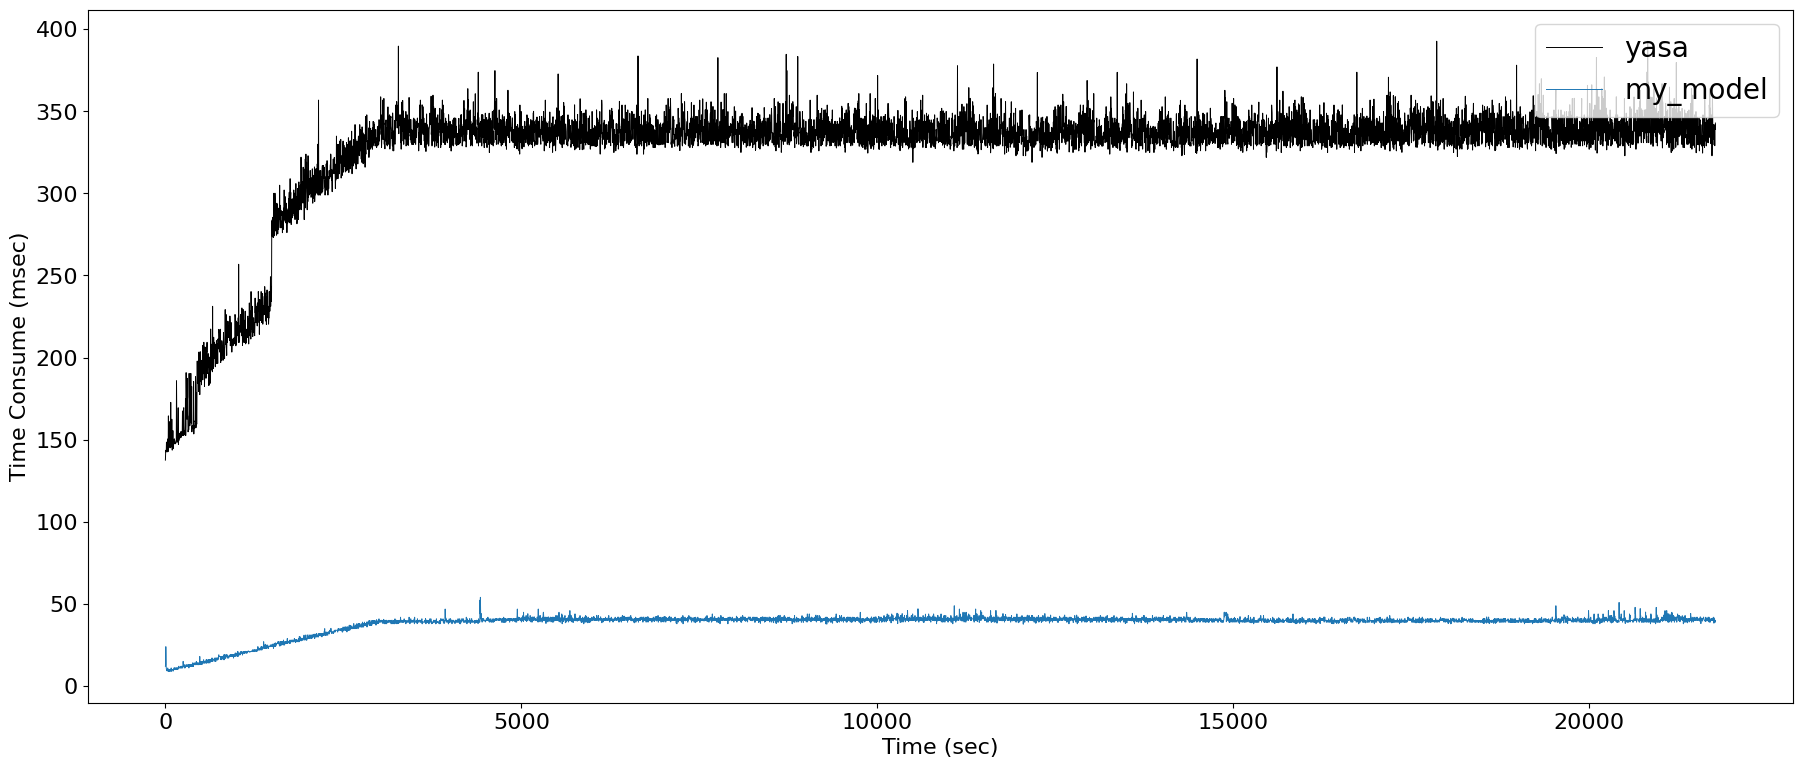

In [143]:
time_go = np.array(range(len(Time_model))) * 3
fig = plt.figure(figsize=(22,9))
# plt.title("Time Consume", fontsize=26)

plt.plot(time_go, Time_yasa * 1000, "k", lw=0.7, label="yasa")
plt.plot(time_go, Time_model * 1000, lw=0.7, label="my_model")

plt.ylabel('Time Consume (msec)', fontsize=16)
plt.xlabel('Time (sec)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc=1, fontsize=20)
plt.savefig(path + "/saveImg/TimeConsume.png")
plt.show()

In [ ]:
# 第一步：创建一个figure，figsize参数设置figure的长和宽
fig = plt.figure(figsize=(25, 9))
# plt.title("Offline Hypnogram", fontsize=26)


# 第二步，快速创建单行或单列布局的多子图（多行多列不支持）。sharey表示共用Y轴
ax1, ax2 = fig.subplots(2, 1, sharey=True)

# 第三步，逐个创建子图，一个 ax 就是一个子图
# ax1作图，并设置X,Y轴名称，以及设置图上方的标题
ax1 = my_plot_hypnogram(Offline_yasa, sf_hypno=1, ax=ax1)
ax1.set_xlabel('Time[hrs]', fontsize=18)
ax1.set_ylabel('Stage', fontsize=20)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=16)
# ax1.set_title("Predicted by yasa", fontsize=22, loc="left")
ax1.set_title("Yasa-OL", fontsize=26, loc="left")

# ax2作图，并设置X轴名称，以及设置图上方的标题
ax2 = my_plot_hypnogram(Offline_model, sf_hypno=1, ax=ax2)
ax2.set_xlabel('Time[hrs]', fontsize=18)
ax2.set_ylabel('Stage', fontsize=20)
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=16)
# ax2.set_title("Predicted by model", fontsize=22, loc="left")
ax2.set_title("Model-OL", fontsize=26, loc="left")

# 第四步，设置fig的标题，比ax1，ax2，ax3的标题更高一级
fig.tight_layout()
# plt.savefig(path + "/saveImg/hypnogram_Offline.png")

# 第五步，展示图
plt.show()


dataFrame_OL

In [ ]:
Realtime_yasa = np.load(path + "/Realtime_yasa.npy")
Realtime_model = np.load(path + "/Realtime_model.npy")
Time_yasa = np.load(path + "/Realtime_yasa_time.npy")
Time_model = np.load(path + "/Realtime_model_time.npy")

In [ ]:
# 第一步：创建一个figure，figsize参数设置figure的长和宽
fig = plt.figure(figsize=(25, 9))
# plt.title("Offline Hypnogram", fontsize=26)


# 第二步，快速创建单行或单列布局的多子图（多行多列不支持）。sharey表示共用Y轴
ax1, ax2 = fig.subplots(2, 1, sharey=True)

# 第三步，逐个创建子图，一个 ax 就是一个子图
# ax1作图，并设置X,Y轴名称，以及设置图上方的标题
ax1 = my_plot_hypnogram(Realtime_yasa, sf_hypno=1, ax=ax1)
ax1.set_xlabel('Time[hrs]', fontsize=18)
ax1.set_ylabel('Stage', fontsize=20)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=16)
# ax1.set_title("Predicted by yasa", fontsize=22, loc="left")
ax1.set_title("Yasa-RT", fontsize=26, loc="left")

# ax2作图，并设置X轴名称，以及设置图上方的标题
ax2 = my_plot_hypnogram(Realtime_model, sf_hypno=1, ax=ax2)
ax2.set_xlabel('Time[hrs]', fontsize=18)
ax2.set_ylabel('Stage', fontsize=20)
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=16)
# ax2.set_title("Predicted by model", fontsize=22, loc="left")
ax2.set_title("Model-RT", fontsize=26, loc="left")

# 第四步，设置fig的标题，比ax1，ax2，ax3的标题更高一级
fig.tight_layout()
plt.savefig(path + "/saveImg/hypnogram_Offline.png")

# 第五步，展示图
plt.show()

result_matrix_RT, dataFrame_RT, ACC_RT = benchmark(Realtime_yasa, Realtime_model)
dataFrame_RT

In [ ]:
# 第一步：创建一个figure，figsize参数设置figure的长和宽
fig = plt.figure(figsize=(25, 9))
# plt.title("Offline Hypnogram", fontsize=26)


# 第二步，快速创建单行或单列布局的多子图（多行多列不支持）。sharey表示共用Y轴
ax1, ax2 = fig.subplots(2, 1, sharey=True)

# 第三步，逐个创建子图，一个 ax 就是一个子图
# ax1作图，并设置X,Y轴名称，以及设置图上方的标题
ax1 = my_plot_hypnogram(Offline_yasa, sf_hypno=1, ax=ax1)
ax1.set_xlabel('Time[hrs]', fontsize=18)
ax1.set_ylabel('Stage', fontsize=20)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=16)
# ax1.set_title("Predicted by yasa", fontsize=22, loc="left")
ax1.set_title("Yasa-OL", fontsize=26, loc="left")

# ax2作图，并设置X轴名称，以及设置图上方的标题
ax2 = my_plot_hypnogram(Realtime_model, sf_hypno=1, ax=ax2)
ax2.set_xlabel('Time[hrs]', fontsize=18)
ax2.set_ylabel('Stage', fontsize=20)
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=16)
# ax2.set_title("Predicted by model", fontsize=22, loc="left")
ax2.set_title("Model-RT", fontsize=26, loc="left")

# 第四步，设置fig的标题，比ax1，ax2，ax3的标题更高一级
fig.tight_layout()
plt.savefig(path + "/saveImg/hypnogram_OL_RT_Compare.png")

# 第五步，展示图
plt.show()

result_matrix_OL_RT, dataFrame_OL_RT, ACC_OL_RT = benchmark(Offline_yasa, Realtime_model)
dataFrame_OL_RT

In [ ]:
result_matrix_Yasa, dataFrame_Yasa, ACC_Yasa = benchmark(Offline_yasa, Realtime_yasa)
dataFrame_Yasa

In [ ]:
result_matrix_Model, dataFrame_Model, ACC_Model = benchmark(Offline_model, Realtime_model)
dataFrame_Model